### 1. Cluster genes based on expression correlation and show behavior of clusters in a heatmap

We calculate average expression values for the three replicates, per probe --> calculate_average_expression_levels.ipynb 

We cluster genes based on their average expression values at different timepoints and plot the clustering as a heatmap.

In [3]:
# Assume notebook is in [workingdir]/notebooks and data is in [workingdir]/data. 
# Results will be stored in [workingdir]/results

import os
if os.getcwd().split('/')[-1] == 'notebooks': 
    os.chdir('..') # move one directory up to [workingdir]
    
workingdir = os.getcwd()

print('Assuming data is stored in '+workingdir+'/data/, results will be stored in '+workingdir+'/results/')
os.system('mkdir -p results')
os.system('mkdir -p results/DEGs_in_Pad4/')
os.system('mkdir -p results/DEGs_in_Pad4/pickles/')

os.system('mkdir -p util')
os.system('mkdir -p util/pickles')

Assuming data is stored in /Users/like/Dropbox/00.Projects/Like_Harrold/repository/data/, results will be stored in /Users/like/Dropbox/00.Projects/Like_Harrold/repository/results/


0

First we select which genes are differentially expressed in time, for each strain.
We check our results using a Venn (should be the same as generated in 0.Venn_diagrams_timepoints_mutants)

We create a list of probesets of diff. expr. probes, per comparison `probesets` and a set of all probes that are diff. expr. in any of the comparisons `allDEGs`


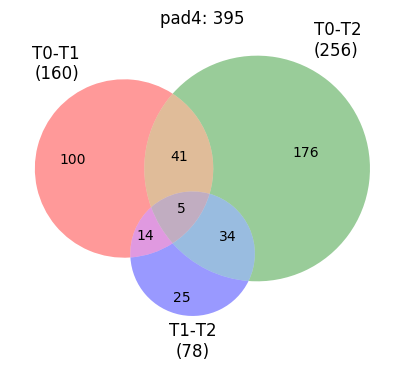

In [7]:
import pickle
import utils # utils.py contains several functions that are used in multiple notebooks

# specific imports for making Venn diagrams
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
%matplotlib inline
#

maxQ = 0.01
S = 'pad4'
timepoints  = ['T0','T1','T2']
dirnameTime = 'data/reanalysisTime/'


# For each strain, the overlap in DEGs per timepoint comparison
probesets = []
labels    = []
allDEGs   = set([])
p2t       = utils.probe2transcripts('data/probeset_id2transcript_id.tab')
for x, Tx in enumerate(timepoints[:-1]):
    for y, Ty in enumerate(timepoints[x+1:]):

        # select DEGs in strains when comparing timepoint Tx to Ty
        probes = utils.select_probes(dirnameTime+S+'_'+Tx+'_vs_'+Ty+'.txt', maxQ)
        
        # write transcripts to a file 
        data_fname      = 'results/DEGs_in_Pad4/'+Tx+'-'+Ty+'.txt'
        transcript_file = open(data_fname, 'w')
        
        for p in probes:
            if p2t.has_key(p):
                for t in p2t[p]:
                    transcript_file.write(t+'\n')
            else:
                print 'Probe not found', p 
        
        transcript_file.close()
        
        pickle.dump(probes, open('results/DEGs_in_Pad4/pickles/'+Tx+'-'+Ty+'.probes_as_set', 'w'))
        probesets.append(probes)
        allDEGs = allDEGs.union(probes)
        labels.append(Tx+'-'+Ty+'\n('+str(len(probes))+')')  

pickle.dump(allDEGs, open('results/DEGs_in_Pad4/pickles/ALL.probes_as_set', 'w'))        
            
plt.figure()
plt.title(S+': '+str(len(allDEGs)))
venn = venn3(probesets, set_labels = labels)



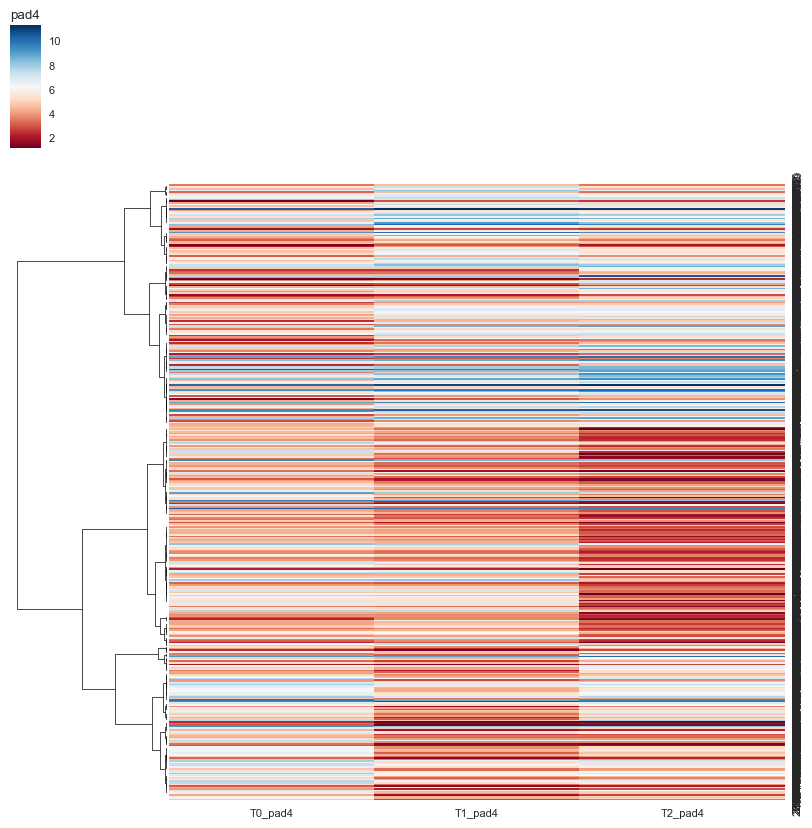

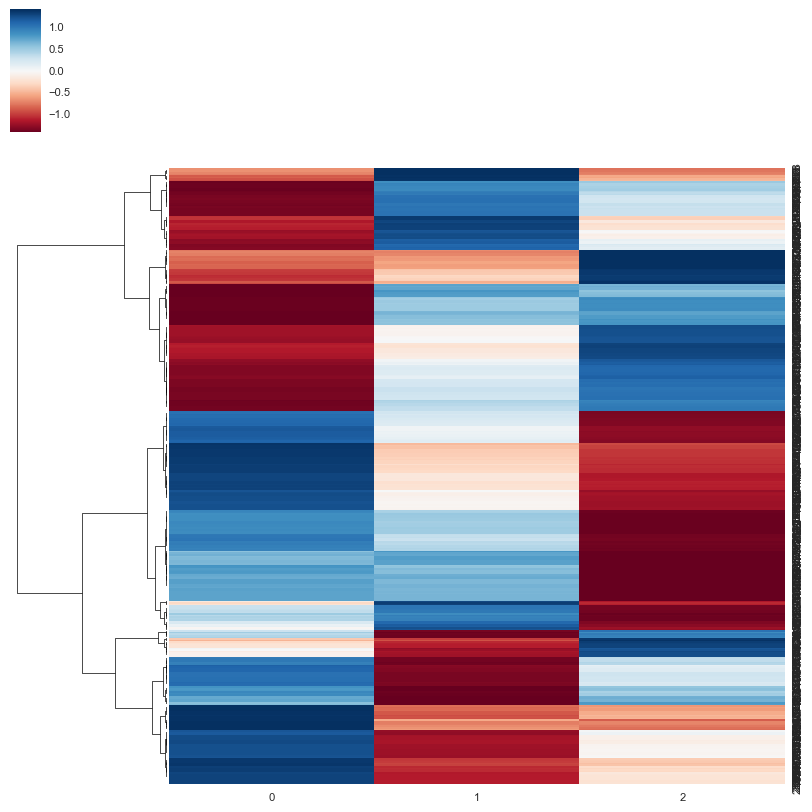

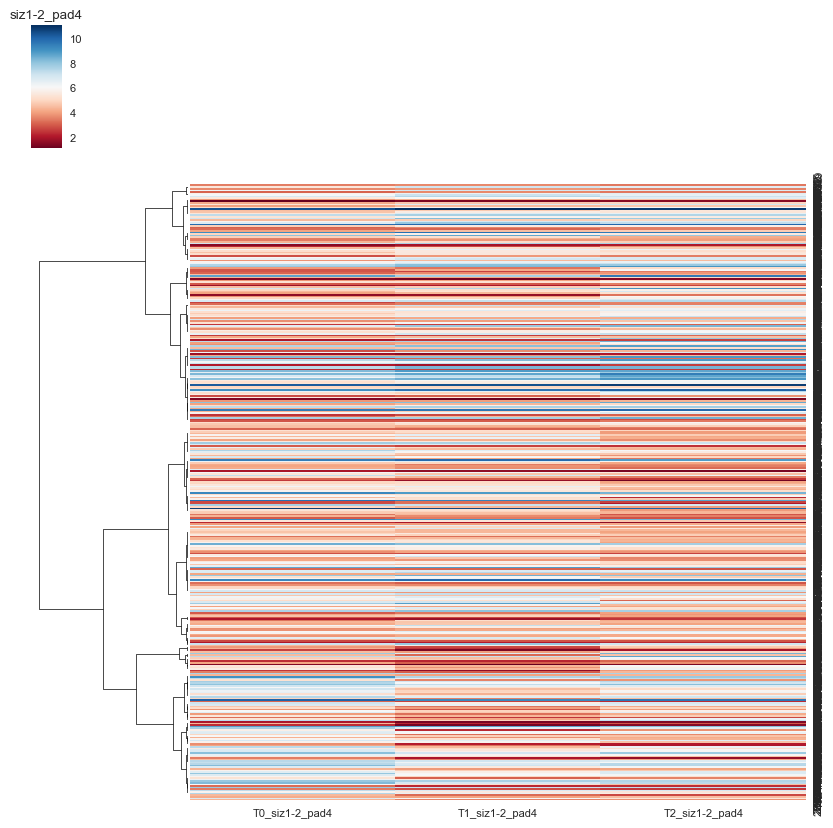

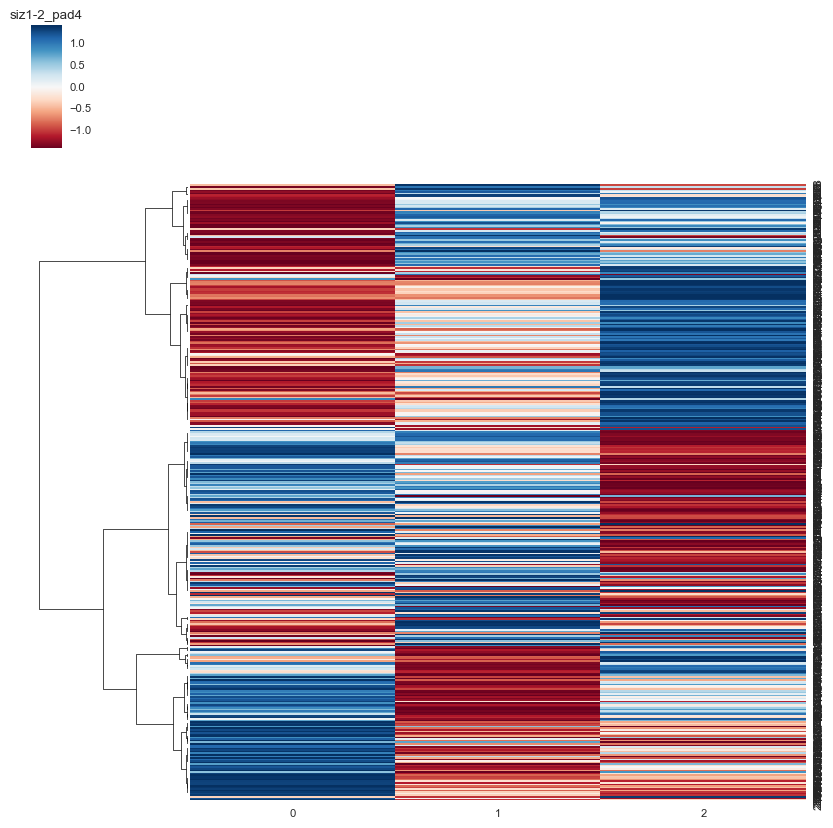

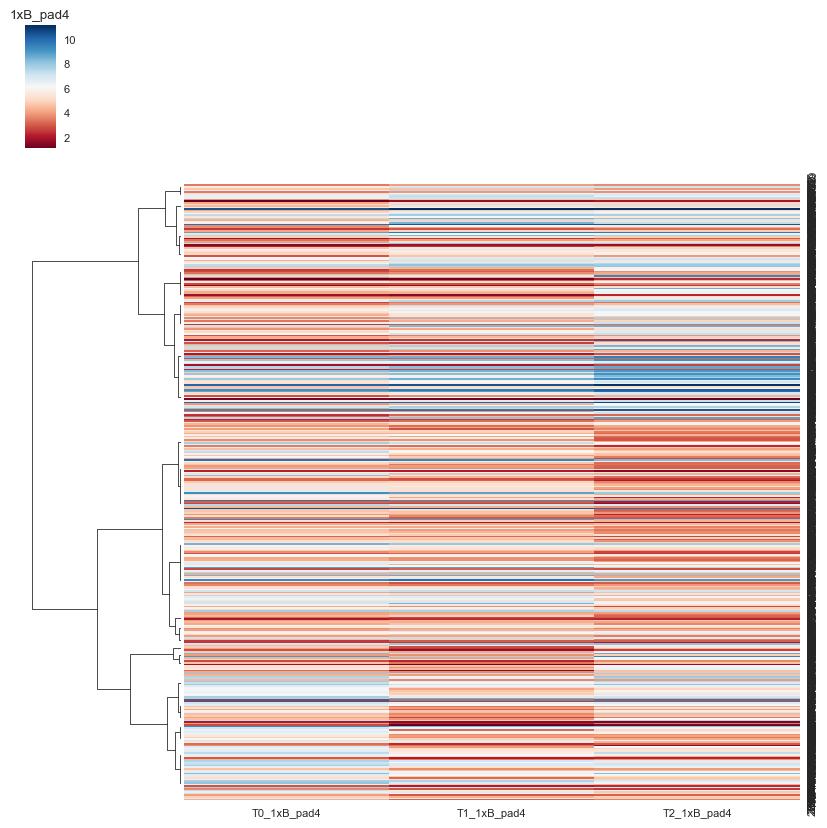

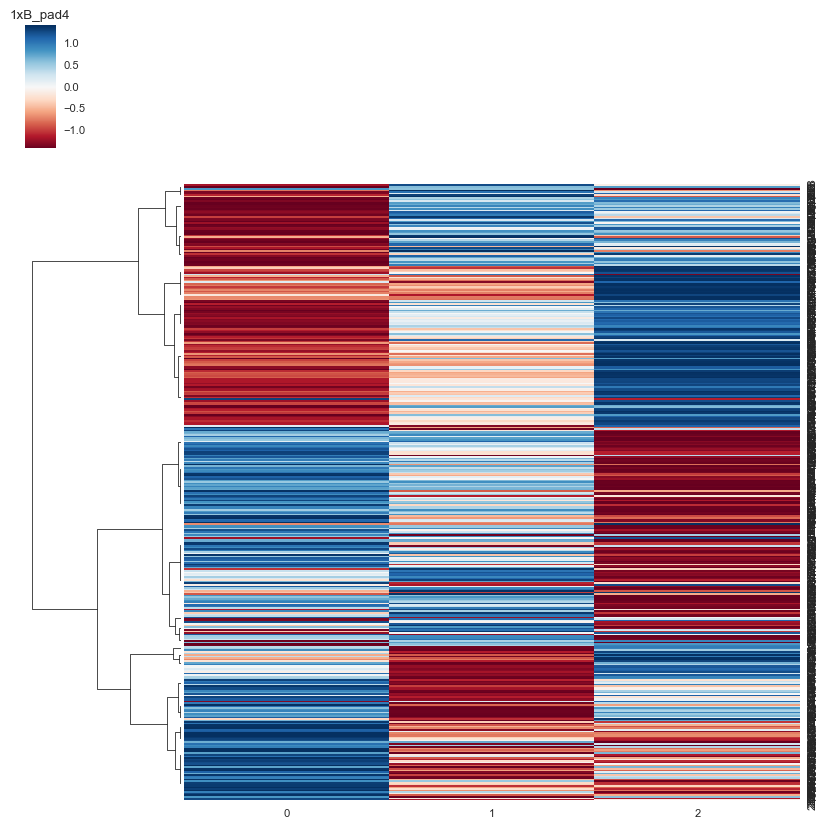

In [13]:
import sys
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
sns.set_context("paper")

from scipy import stats

from scipy.spatial import distance
from scipy.cluster import hierarchy
from sklearn import preprocessing

# Create output directories
os.system('mkdir -p results/heatmaps/')

# Read average expression values (over 3 replicates) per timepoint per strain per probe
df   = pd.read_csv('results/average_expression.tab', sep = '\t')

# select diff. expressed probes from this table
DEGs = df[df.probeset_id.isin(allDEGs)] 
#print(DEGs)


######
# create heatmap for background strain Pad4:
######
strains = ['pad4', 'siz1-2_pad4', '1xB_pad4']

S = strains[0]
# cluster using UPGMA, save clustering in row_linkage
row_linkage = hierarchy.linkage(distance.pdist(DEGs[['T0_'+S, 'T1_'+S, 'T2_'+S]], \
                                               metric = 'correlation'), method='average')

sns.clustermap(DEGs[['T0_'+S, 'T1_'+S, 'T2_'+S]], row_linkage=row_linkage, col_cluster=False, cmap = 'RdBu')
sns.plt.title(S)
sns.plt.savefig('results/heatmaps/HEATMAP_DEGs_'+S+'_RdBu.eps')
sns.plt.show()

# normalize the data to highlight trends in time rather than expression level
normalized_data = preprocessing.scale(DEGs[['T0_'+S, 'T1_'+S, 'T2_'+S]], \
                  axis=1, with_mean=True, with_std=True, copy=True)

sns.clustermap(normalized_data, row_linkage=row_linkage, col_cluster=False, cmap = 'RdBu')
sns.plt.savefig('results/heatmaps/HEATMAP_DEGs_'+S+'_RdBu_normalizedRows.eps')
sns.plt.show()


for S in strains[1:]:
    
    sns.clustermap(DEGs[['T0_'+S, 'T1_'+S, 'T2_'+S]], row_linkage=row_linkage, col_cluster=False, cmap = 'RdBu')
    sns.plt.title(S)
    sns.plt.savefig('results/heatmaps/HEATMAP_DEGs_'+S+'_RdBu.eps')
    sns.plt.show()


    # normalize the data to highlight trends in time rather than expression level
    normalized_data = preprocessing.scale(DEGs[['T0_'+S, 'T1_'+S, 'T2_'+S]], \
                                         axis=1, with_mean=True, with_std=True, copy=True)
        
    sns.clustermap(normalized_data, row_linkage=row_linkage, col_cluster=False, cmap = 'RdBu')
    sns.plt.title(S)
    
    sns.plt.savefig('results/heatmaps/HEATMAP_DEGs_'+S+'_RdBu_normalizedRows.eps')
    sns.plt.show()







In addition to heatmaps with normalized expression values, we can also display heatmaps with the difference in expression value for the mutant compared to the bkgr. For this we first need to calculate the ratio of expression values: mutant/bkgr. 

Expression values are log transformed, taking the difference of two log-transformed variables is equivalent of taking the log of their ratio: log(X/Y)=log(X)−log(Y)



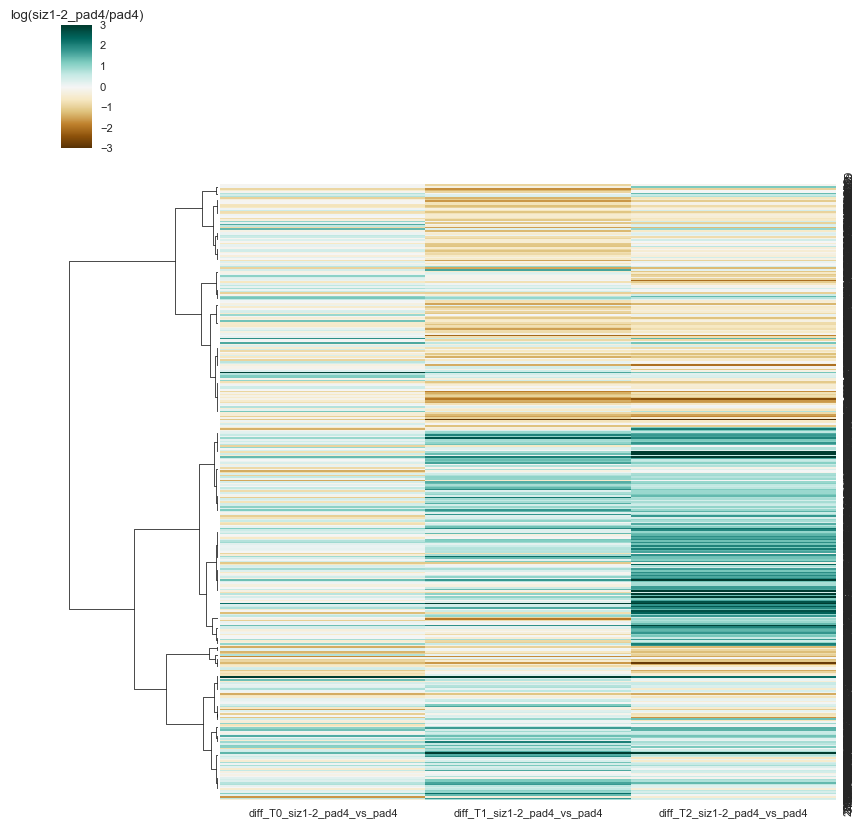

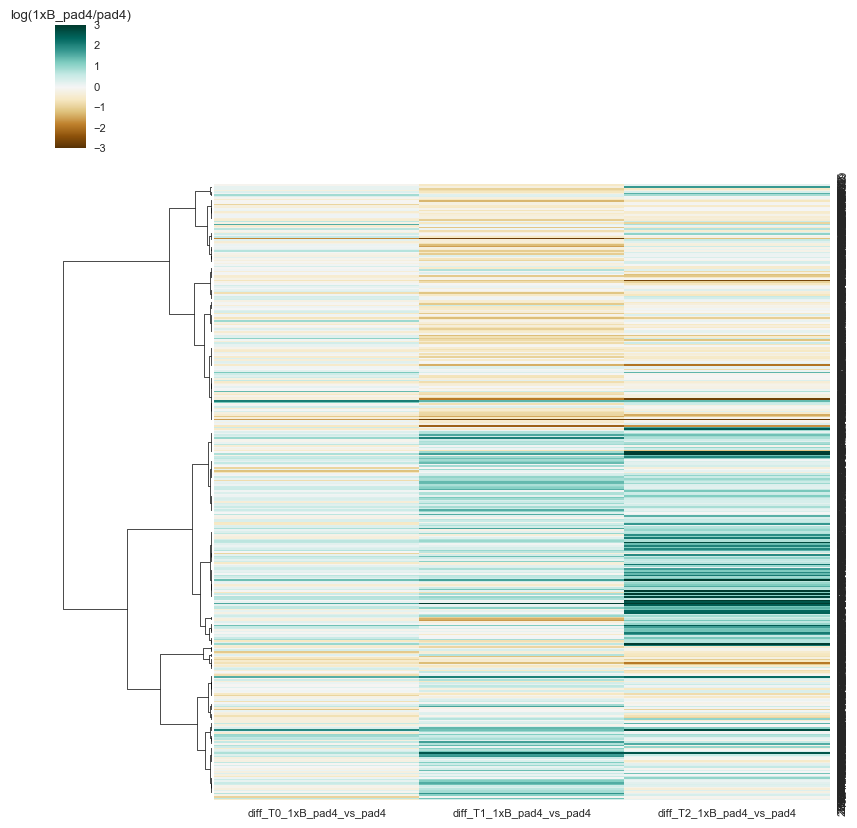

In [14]:
# add extra columns to dataframe with ratio mutant/bkgr:
BKGR = strains[0]
for S in strains[1:]:
    diff_data = pd.DataFrame({'diff_T0_'+S+'_vs_'+BKGR: DEGs['T0_'+S]-DEGs['T0_'+BKGR],\
                           'diff_T1_'+S+'_vs_'+BKGR: DEGs['T1_'+S]-DEGs['T1_'+BKGR],\
                           'diff_T2_'+S+'_vs_'+BKGR: DEGs['T2_'+S]-DEGs['T2_'+BKGR]})


    #Now let's make a heatmap of the differences:
    sns.clustermap(diff_data, row_linkage=row_linkage, col_cluster=False, cmap = 'BrBG',vmin=-3,vmax=3)
    sns.plt.title('log('+S+'/'+BKGR+')')
    sns.plt.savefig('results/heatmaps/HEATMAP_DIFF_DEGs_'+S+'.eps')
    sns.plt.show()
    
  
    


  
  
___

The normalized heatmaps plotted above, are Figure 5a in the paper
___

  
  
  